In [1]:
import glob
import os
import json
import xml.etree.ElementTree as et
import pandas as pd
import soundfile as sf
import numpy as np
from pathlib import Path
import itertools
import matplotlib.pyplot as plt

In [3]:
with open(
        '/Users/ccui/Desktop/asteroid/egs/AMIx/data_statistics/statistics.json',
        "r") as f:
    statistics = json.load(f)


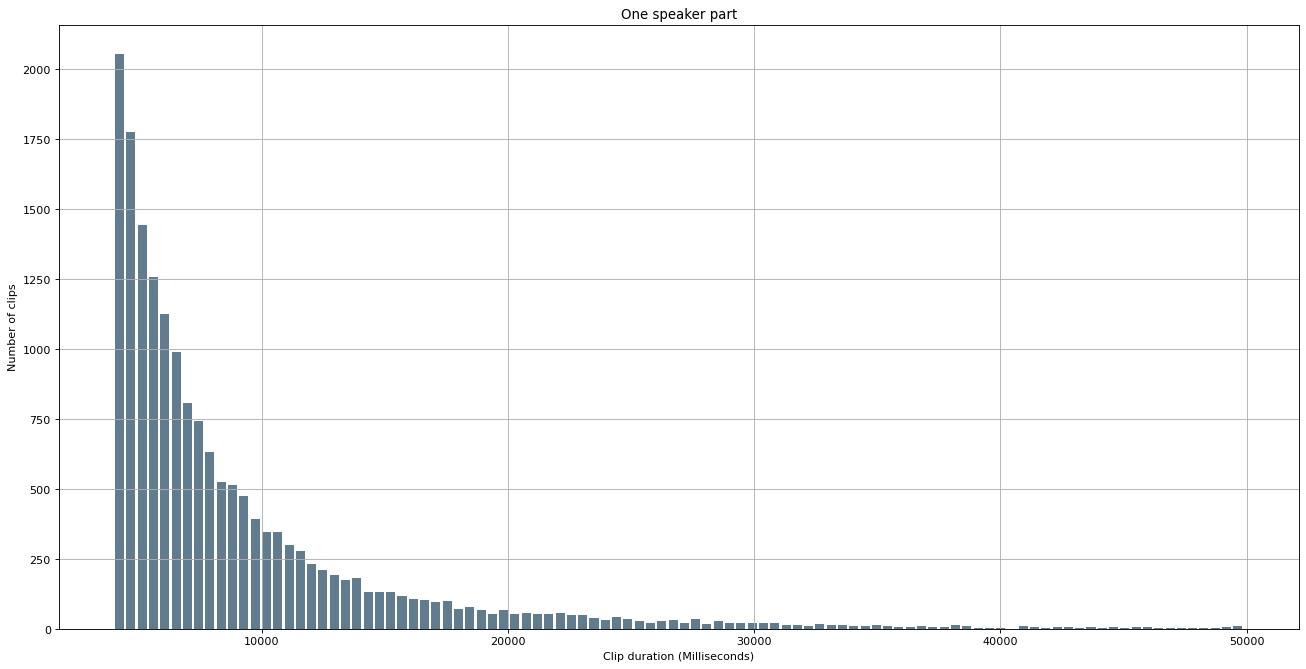

In [6]:
fig = plt.figure(figsize=(20,10),dpi=80)
overlap = pd.Series([s for s in statistics[0] if s>=4000 and s<= 50000])
overlap.plot.hist(grid=True, bins=100, rwidth=0.8,
                color='#607c8e')
plt.xlabel('Clip duration (Milliseconds)')
plt.ylabel('Number of clips')
plt.title('One speaker part')
plt.show()

In [7]:
# Get an Array of all 0's and 1's based on annotation and the total audio length
def get_binary_list(segment_path, total_dur):
    tree = et.parse(segment_path)
    root = tree.getroot()
    # Create an array of all zeros and length total_dur
    segs_arr = np.zeros(total_dur)
    # convert second string to milliseccond int
    segs = [[
        elem.attrib["transcriber_start"],
        elem.attrib["transcriber_end"],
    ] for elem in root.iter("segment")]
    for dur in segs:
        dur[0] = int(float(dur[0]) * 1000)
        dur[1] = int(float(dur[1]) * 1000)
    # Set the value on the array corresponding to the position of each interval in segs to 1
    for seg in segs:
        start_seg = seg[0]
        end_seg = seg[1] + 1
        segs_arr[start_seg:end_seg] = 1
    return segs_arr

In [31]:
array_path = "/Users/ccui/Desktop/AMI_sample/amicorpus/ES2002a/audio/ES2002a.Array1-01.wav"
array, fs = sf.read(
    array_path,
    dtype="float32",
)
total_dur = int(len(array) / fs * 1000)
meeting_name = "ES2002a"
segment_path = "/Users/ccui/Desktop/AMI_sample/annotations/segments"
segment_list = glob.glob(os.path.join(segment_path, "*"))

seg_path_list = []
for seg in segment_list:
    seg_meeting_name = Path(seg).stem.split(".")[0]
    if seg_meeting_name == meeting_name:
        seg_path_list.append(str(Path(seg)))
# print(seg_path_list)
target_spk = "A"
ref_overlap = np.zeros(total_dur)
for index in range(len(seg_path_list)):
    seg_path = seg_path_list[index]
    spk = seg_path.split(".")[1]
    if spk == target_spk:
        target_annot = get_binary_list(seg_path, total_dur)

    else:
        ref_annot = seg_path
        seg_list = get_binary_list(ref_annot, total_dur)
        ref_overlap += seg_list

subtr = target_annot - ref_overlap
target = np.maximum(subtr,0)
print(len(subtr))
print(min(subtr))
print(len(target))
print(min(target))

1272640
-3.0
1272640
0.0


In [51]:
def get_target_from_targetSpk(target_spk,total_dur,seg_path_list):
    ref_overlap = np.zeros(total_dur)
    for index in range(len(seg_path_list)):
        seg_path = seg_path_list[index]
        spk = seg_path.split(".")[1]
        if spk == target_spk:
            target_annot = get_binary_list(seg_path, total_dur)

        else:
            ref_annot = seg_path
            seg_list = get_binary_list(ref_annot, total_dur)
            ref_overlap += seg_list
    
    subtr = target_annot - ref_overlap
    target = np.maximum(subtr,0)
    return target

In [45]:
win_size = 4000 # 4 seconds
thresh = 4000
step = 1000
local_save_dir = "/Users/ccui/Desktop/AMI_sample/clips_monoSpk"

meeting_folder = os.path.join(local_save_dir, meeting_name)
if not os.path.exists(meeting_folder):
    os.makedirs(meeting_folder)

target_spk_folder = os.path.join(meeting_folder, target_spk)
if not os.path.exists(target_spk_folder):
    os.makedirs(target_spk_folder)
start_point_list = list(range(0,len(target)-win_size,step))
clips_seg_list = []
for start_point in start_point_list:
    end_point = start_point + win_size
    seg = target[start_point:end_point]
    if seg.sum() == thresh:
        clips_seg_list.append([start_point,end_point])
print(clips_seg_list)

[[319000, 323000], [320000, 324000], [321000, 325000], [322000, 326000], [323000, 327000], [329000, 333000], [330000, 334000], [331000, 335000], [572000, 576000], [573000, 577000], [574000, 578000], [575000, 579000], [576000, 580000]]


In [47]:
for index in range(len(clips_seg_list)):
    clips_seg = clips_seg_list[index]
    start_clip = int(clips_seg[0]* (fs/1000))
    end_clip = int(clips_seg[1]* (fs/1000))
    sample_folder = os.path.join(target_spk_folder, "sample" + str(index+1))
    if not os.path.exists(sample_folder):
        os.makedirs(sample_folder)
    clip = array[start_clip:end_clip]
    sf.write(
        sample_folder + "/%s_%s.wav" %
        (target_spk, array_path.split(".")[-2]),
        clip,
        fs,
    )
    


In [60]:
def get_clips_from_targetSpk(win_size,thresh,step,target,target_spk,meeting_folder,array_path_list,fs):
    target_spk_folder = os.path.join(meeting_folder, target_spk)
    if not os.path.exists(target_spk_folder):
        os.makedirs(target_spk_folder)
    start_point_list = list(range(0, len(target) - win_size, step))
    clips_seg_list = []
    for start_point in start_point_list:
        end_point = start_point + win_size
        seg = target[start_point:end_point]
        if seg.sum() == thresh:
            clips_seg_list.append([start_point, end_point])
    for index in range(len(clips_seg_list)):
        clips_seg = clips_seg_list[index]
        start_clip = int(clips_seg[0]* (fs/1000))
        end_clip = int(clips_seg[1]* (fs/1000))
        sample_folder = os.path.join(target_spk_folder, "sample" + str(index+1))
        if not os.path.exists(sample_folder):
            os.makedirs(sample_folder)
        for array_path in array_path_list:
            array, fs = sf.read(
            array_path,
            dtype="float32",
            )
            clip = array[start_clip:end_clip]
            sf.write(
                sample_folder + "/%s_%s.wav" %
                (target_spk, array_path.split(".")[-2]),
                clip,
                fs,
            )


In [71]:
in_dir = "/Users/ccui/Desktop/AMI_sample/amicorpus"
folder_list = glob.glob(os.path.join(in_dir, "*"))
segment_path = "/Users/ccui/Desktop/AMI_sample/annotations/segments"
segment_list = glob.glob(os.path.join(segment_path, "*"))
local_save_dir = "/Users/ccui/Desktop/AMI_sample/clips_monoSpk"
win_size = 4000  # 4 seconds
thresh = 4000
step = 1000


for folder in folder_list:
    wavs = glob.glob(os.path.join(folder, "audio/*"))
    meeting_name = Path(folder).stem.split(".")[-1]
    meeting_folder = os.path.join(local_save_dir, meeting_name)
    if not os.path.exists(meeting_folder):
        os.makedirs(meeting_folder)
    # Get all array channels of this meeting
    array_path_list = []
    for wav in wavs:
        mic_type = Path(wav).stem.split(".")[-1].split("-")[0]
        if mic_type in ["Array1", "Array2"]:
            array_path_list.append(str(Path(wav)))
    # Get all seg annotations of this meeting
    seg_path_list = []
    spk_list = []
    for seg in segment_list:
        seg_meeting_name = Path(seg).stem.split(".")[0]
        if seg_meeting_name == meeting_name:
            seg_path_list.append(str(Path(seg)))
            spk = seg.split(".")[-3]
            spk_list.append(spk)
    # Get reference audio duration
    array_ref, fs = sf.read(
    array_path_list[0],
    dtype="float32",
    )
    total_dur = int(len(array_ref) / fs * 1000)
    for target_spk in spk_list:
        target = get_target_from_targetSpk(target_spk,total_dur,seg_path_list)
        seg_dur = [
            len(list(v)) for k, v in itertools.groupby(target) if k == 1
        ]
        if max(seg_dur) >= thresh:
            get_clips_from_targetSpk(win_size, thresh, step, target, target_spk,
                                     meeting_folder, array_path_list,fs)
    break


8934
8833
6568
75082


In [73]:
f1 = open('oar100.txt', 'w')
for idx in range(1, 172):
    idx_s = str(idx)
    f1.write('%s\n' % (idx_s))
f1.close()